### ESTOU ME BASEANDO QUE A VARIÁVEL TARGET SEJA A VARIÁVEL rv1.

Importando bibliotecas que serão utilizadas durante o desenvolvimento.

In [13]:
import warnings
warnings.filterwarnings('ignore')

import sys

# Bibliteca para Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para Manipulação de Dados
import pandas as pd
import numpy as np

# Biblioteca para Análise e modelagem de séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para formatação dos gráficos
import matplotlib.cbook
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

# Imports para criação e validação dos modelos temporais
from statsmodels.tsa.arima_model import ARIMA
import sklearn
from sklearn.metrics import mean_squared_error 
import itertools

# Import para Padronização dos dados
from sklearn.preprocessing import StandardScaler

# Import utilizado para Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

# Import utilizado para análise de MultiColinearidade dos Dados
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import para Análise de Estacionaridade nos Modelos de Séries Temporais
from statsmodels.tsa.stattools import adfuller

# Import para obter os feriados usados no Modelo SARIMAX Exógeno
import holidays

# Import Modelo de Séries Temporais Multivariado
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports para o modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Import para aplicar Cross Validation
from sklearn.model_selection import cross_val_score

# Import para definir os KFold do CV
from sklearn.model_selection import RepeatedKFold

# Import para Otimização de HiperParametros
from sklearn.model_selection import GridSearchCV

# Import para o modelo de Regressão Linear
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('ggplot')

%matplotlib inline

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset_training.csv
/kaggle/input/dataset_testing.csv


In [15]:
# Import Dataset de Treino.
df_train = pd.read_csv('/kaggle/input/dataset_training.csv')
df_test = pd.read_csv('/kaggle/input/dataset_training.csv')

In [16]:
# Unificando o df_train e df_test pois lá na frente iremos utilizar séries temporais e os dados a serem previstos 
# devem ser os mais atuais possível.
df_full = pd.concat([df_train, df_test])
df_full = df_full.sort_values(['date'], ascending=True)
df_full.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday


# Análise Exploratória

In [17]:
df_train.shape

(14803, 32)

In [18]:
df_test.shape

(14803, 32)

In [19]:
df_full.shape

(29606, 32)

T > Temperatura

RH >  Umidade Relativa (Relative Humidity)

T_out > Temperatura do lado de fora da casa

RH_out > Umidade do lado de fora da casa

mm_hg > Unidade de pressão

In [20]:
# Considerando a variável rv1 como a TARGET do dataset
column_target = 'rv1'

In [21]:
# Analisando as informações de cada dado
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29606 entries, 0 to 14802
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         29606 non-null  object 
 1   Appliances   29606 non-null  int64  
 2   lights       29606 non-null  int64  
 3   T1           29606 non-null  float64
 4   RH_1         29606 non-null  float64
 5   T2           29606 non-null  float64
 6   RH_2         29606 non-null  float64
 7   T3           29606 non-null  float64
 8   RH_3         29606 non-null  float64
 9   T4           29606 non-null  float64
 10  RH_4         29606 non-null  float64
 11  T5           29606 non-null  float64
 12  RH_5         29606 non-null  float64
 13  T6           29606 non-null  float64
 14  RH_6         29606 non-null  float64
 15  T7           29606 non-null  float64
 16  RH_7         29606 non-null  float64
 17  T8           29606 non-null  float64
 18  RH_8         29606 non-null  float64
 19  T9  

In [22]:
# Resumo estatístico dos dados
df_full.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
count,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,...,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000,29606.000000
mean,98.011214,3.802608,21.684167,40.271439,20.342506,40.418056,22.262628,39.249149,20.855433,39.030359,...,41.542065,7.413018,755.502983,79.734122,4.034470,38.330141,3.756859,25.078087,25.078087,42985.989326
std,102.826283,7.940206,1.607753,3.981674,2.191805,4.066154,2.013751,3.252700,2.044752,4.339709,...,4.150769,5.323753,7.427559,14.955357,2.436829,11.812580,4.200226,14.481292,14.481292,24968.227328
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.893333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.730000,37.360833,18.823333,37.900000,20.790000,36.900000,19.500000,35.530000,...,38.500000,3.666667,750.866667,70.000000,2.000000,29.000000,0.900000,12.577848,12.577848,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.863333,6.900000,756.100000,83.666667,3.666667,40.000000,3.450000,25.043993,25.043993,43200.000000
75%,100.000000,0.000000,22.600000,43.090000,21.500000,43.290000,23.290000,41.762500,22.100000,42.131667,...,44.363333,10.400000,760.933333,91.666667,5.500000,40.000000,6.533333,37.666271,37.666271,64800.000000
max,1080.000000,50.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.063333,...,53.326667,25.966667,772.300000,100.000000,13.500000,66.000000,15.500000,49.996530,49.996530,85800.000000


###### Os dados estão todos em Escalas diferentes um do outro. Isso dificulta o treinamento de alguns modelos.
###### Irei aplicar a Padronização dos dados de modo que a média de todos os dados se aproximem o máximo de 0 e o desvio padrão como 1.

### Primeiras manipulações no Dataset Treino

In [23]:
def formata_dados(dataset):
    # Convertendo a coluna date para o formato DateTime
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')
     
    # Aplicando o Split de alguns dados do campo Date  Obs.: O Campo Day_of_week vai ser transformado em inteiro.
    dataset['Month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['hour'] = dataset['date'].dt.hour
    dataset['Day_of_week'] = dataset['date'].dt.dayofweek

    # Renomeando a variável WeekStatus para Weekend. Essa variável terá valores 0 e 1. {0 : Weekday , 1: Weekend}
    dataset.rename(columns={'WeekStatus':'Weekend'}, inplace=True)

    # Segunda Feira = 0 ... Sabado = 5, Domingo = 6
    dataset['Weekend'] = 0
    dataset.loc[(dataset.Day_of_week == 5) | (dataset.Day_of_week == 6), 'Weekend'] = 1    
    
    # Padronizando o nome das colunas para Lower
    dataset.columns = map(str.lower, dataset.columns)
    
    return dataset

In [24]:
df_train = formata_dados(df_train)
df_test = formata_dados(df_test)
df_full = formata_dados(df_full)

In [25]:
df_full.columns 

Index(['date', 'appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3',
       'rh_3', 't4', 'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8',
       'rh_8', 't9', 'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed',
       'visibility', 'tdewpoint', 'rv1', 'rv2', 'nsm', 'weekend',
       'day_of_week', 'month', 'day', 'hour'],
      dtype='object')

In [26]:
df_full.head(5)

,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,...,visibility,tdewpoint,rv1,rv2,nsm,weekend,day_of_week,month,day,hour
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,63.000000,5.3,13.275433,13.275433,61200,0,0,1,11,17
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,63.000000,5.3,13.275433,13.275433,61200,0,0,1,11,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,59.166667,5.2,18.606195,18.606195,61800,0,0,1,11,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,59.166667,5.2,18.606195,18.606195,61800,0,0,1,11,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,55.333333,5.1,28.642668,28.642668,62400,0,0,1,11,17


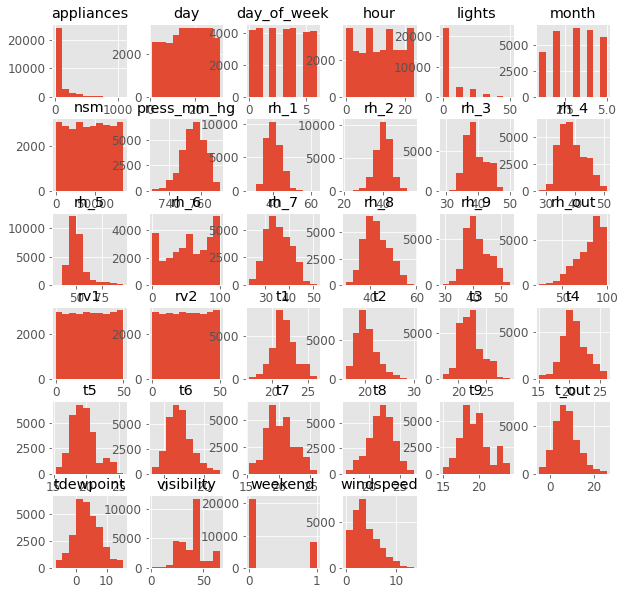

In [27]:
df_full.hist(figsize=(10,10));

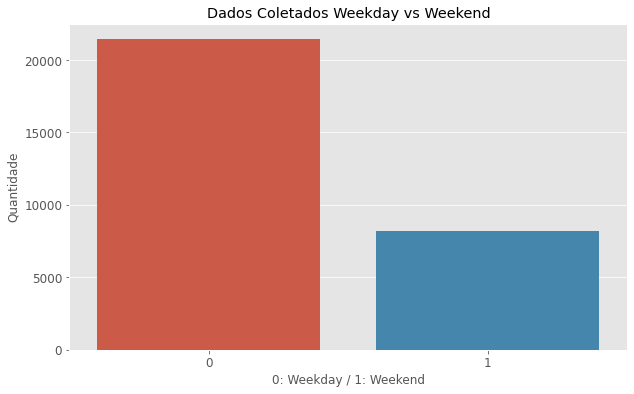

In [28]:
# Quantidade de dados coletados Weekend e WeekDay
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(df_full['weekend'])

ax.set_title('Dados Coletados Weekday vs Weekend')
ax.set_ylabel('Quantidade')
ax.set_xlabel('0: Weekday / 1: Weekend');

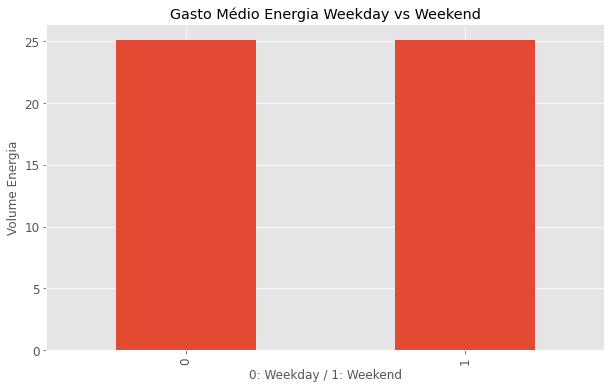

In [29]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('weekend').mean()[column_target].plot(kind='bar')

ax.set_title('Gasto Médio Energia Weekday vs Weekend')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('0: Weekday / 1: Weekend');

In [30]:
df_full.groupby('day_of_week').mean()[column_target]

day_of_week
0    24.294053
1    25.203172
2    25.500469
3    25.074789
4    25.202532
5    25.152816
6    25.101316
Name: rv1, dtype: float64

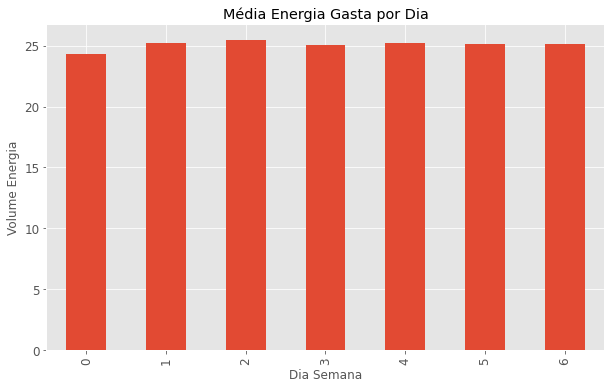

In [31]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('day_of_week').mean()[column_target].plot(kind='bar')

ax.set_title('Média Energia Gasta por Dia')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('Dia Semana');

O Gasto médio de energia no FDS e em dias de semana representam o mesmo gasto. Tomando como base que possui 5 dias Weekday e apenas 2 Weekend, o gasto nos FDS são relativamente maiores baseado na proporção da distribuição dos dados.

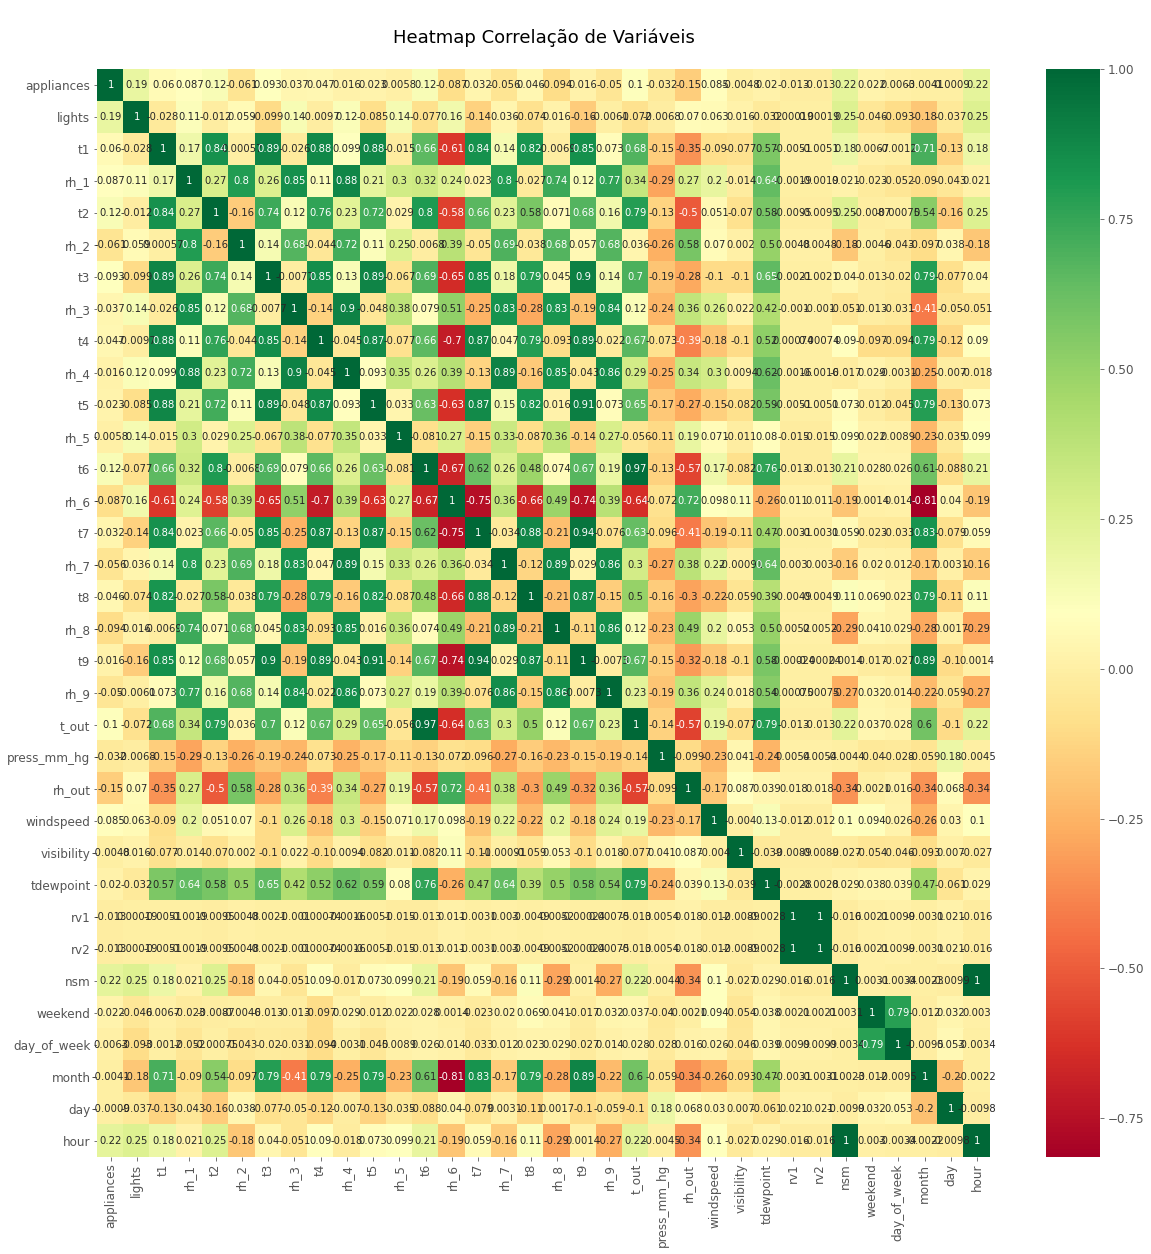

In [32]:
corrmat = df_full.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20,20))
plt.title('\nHeatmap Correlação de Variáveis\n', fontsize=18)

g=sns.heatmap(df_full[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [33]:
# Variavel nsm e hour são altamente correlacionadas. Drop Coluna Hour.
df_train.drop('hour', axis=1, inplace=True)
df_test.drop('hour', axis=1, inplace=True)
df_full.drop('hour', axis=1, inplace=True)

In [34]:
# Variavel rv1 e rv2 são altamente correlacionadas e possuem a mesma informação. Vamos Dropar uma das colunas.
df_train.drop('rv2', axis=1, inplace=True)
df_test.drop('rv2', axis=1, inplace=True)
df_full.drop('rv2', axis=1, inplace=True)

In [35]:
# Definindo a variavel date como Index do Dataset. 
# Essa operação transforma os dados em séries possibilitando a análise como Series Temporais.
df_full.index = df_full['date']
df_full = df_full.drop('date', 1)
df_full.head(5)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,61200,0,0,1,11
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,61200,0,0,1,11
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,61800,0,0,1,11
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,61800,0,0,1,11
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,62400,0,0,1,11


In [36]:
df_train.index = df_train['date']
df_train = df_train.drop('date', 1)

df_test.index = df_test['date']
df_test = df_test.drop('date', 1)

# Seleção de Atributos com Random Forest

In [37]:
# Utilizando Random Forest Regressor para identificar as melhores variáveis preditoras
X = df_full.loc[:, df_full.columns != column_target]
y = df_full.loc[:, df_full.columns == column_target]
model2 = RandomForestRegressor()
rfecv2 = RFECV(estimator=model2, cv=4)
m_rfecv = rfecv2.fit(X,y)

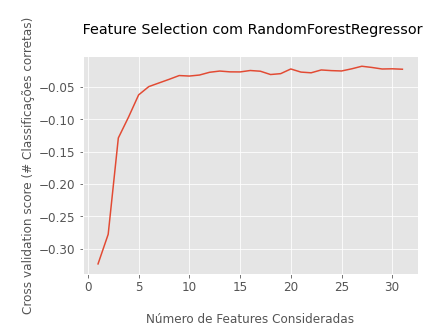


Variáveis Preditoras: Index(['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm', 'weekend', 'day_of_week', 'month'],
      dtype='object')

Variáveis Selecionadas: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False]

Ranking dos Atributos: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 3 4 2]

Número de Melhores Atributos: 27


In [38]:
# Plotando o resultado do feature selection com RandomForestRegressor
plt.figure()
plt.title("\n Feature Selection com RandomForestRegressor\n")
plt.xlabel("\nNúmero de Features Consideradas")
plt.ylabel("\nCross validation score (# Classificações corretas)")
plt.plot(range(1, len(m_rfecv.grid_scores_) + 1), m_rfecv.grid_scores_)
plt.show()

# Print dos resultados
print("\nVariáveis Preditoras:", X.columns[:-1])
print("\nVariáveis Selecionadas: %s" % m_rfecv.support_)
print("\nRanking dos Atributos: %s" % m_rfecv.ranking_)
print("\nNúmero de Melhores Atributos: %d" % m_rfecv.n_features_)

# Análise Série Temporal

In [39]:
# Analisando Multicolinearidade entre os dados
vif = pd.DataFrame()
vif['Feature']= df_full.loc[:, df_full.columns != column_target].columns
vif['VIF Factor'] = [variance_inflation_factor(df_full.loc[:, df_full.columns != column_target].values, i) for i in range(df_full.loc[:, df_full.columns != column_target].shape[1])]

vif.round(1).head(100)

,Feature,VIF Factor
0,appliances,2.3
1,lights,1.6
2,t1,3700.3
3,rh_1,1715.2
4,t2,2547.6
5,rh_2,2200.5
6,t3,1372.2
7,rh_3,1651.8
8,t4,1060.3
9,rh_4,1470.4


In [40]:
# Pegando a data a cada X dias
def qtd_data(df_series, qtd):
    list_date = []
    control = 0
    
    for i in df_series.index.values:
        if control > qtd:
            control = 1        
    
        if control == 0 or control == qtd:
            list_date.append(i)
            control = control + 1
        else:
            control = control + 1        
    
    return list_date

### Realizando um agrupamento Diário para ter um paradigma de como está o consumo médio energia total.

In [41]:
df_full_series_Dia = df_full[column_target].resample('D').mean()

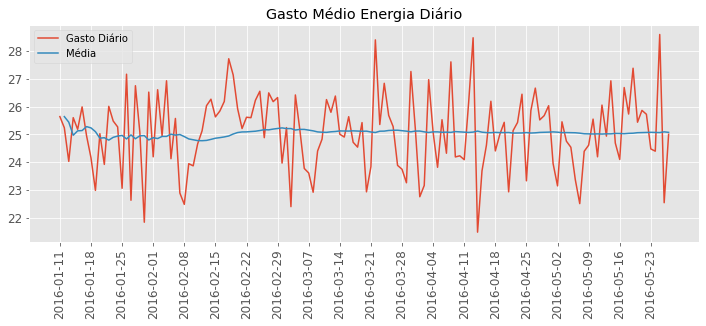

In [42]:
mean_ = [np.mean(df_full_series_Dia[:x]) for x in range(len(df_full_series_Dia))]
mean_series_Dia = pd.Series(mean_)
mean_series_Dia.index = df_full_series_Dia.index

fig, ax = plt.subplots(figsize = (12,4))
plt.plot(df_full_series_Dia, label = 'Gasto Diário')
plt.plot(mean_series_Dia, label = 'Média')
plt.legend()
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

ax.set_title('Gasto Médio Energia Diário');

Podemos observar que a série de gasto Médio de Energia Diário possui uma média Constante. Vamos verificar se é uma série estacionária ou não utilizando o modelo de Dickey Fuller.

#### Vamos Decompor a Série em 3 partes: Tendência, Sazonalidade e Resíduo.

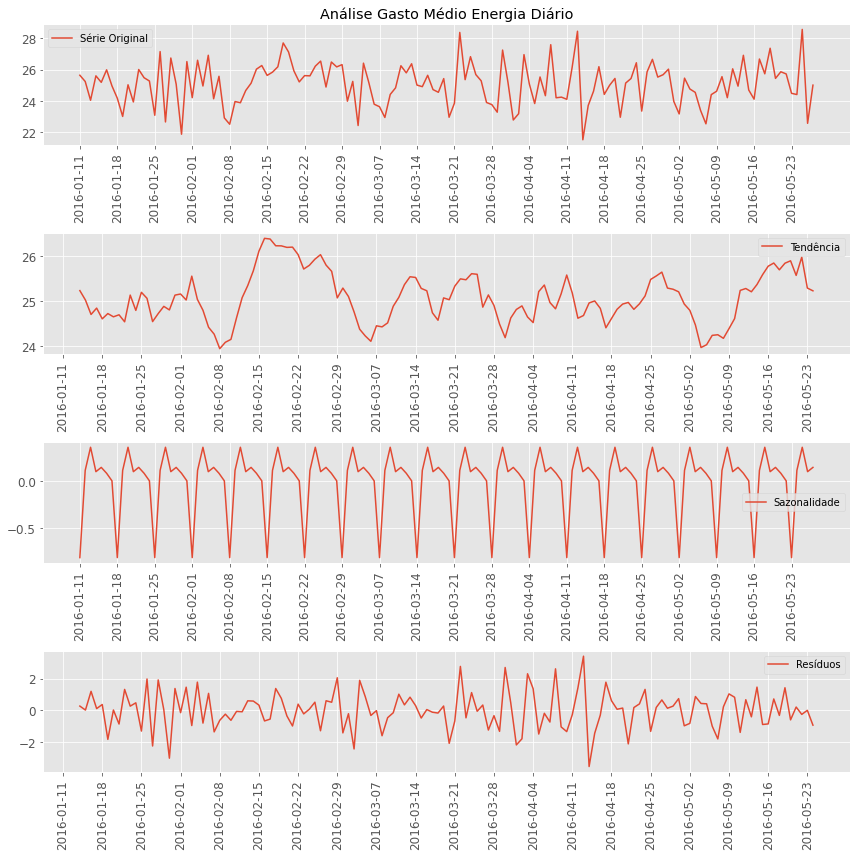

In [43]:
matplotlib.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,12))

res = seasonal_decompose(df_full_series_Dia)

plt.subplot(411)
plt.plot(res.observed, label = 'Série Original')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))
plt.title('Análise Gasto Médio Energia Diário')

plt.subplot(412)
plt.plot(res.trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.subplot(413)
plt.plot(res.seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.subplot(414)
plt.plot(res.resid, label = 'Resíduos')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.tight_layout();

Observações:

- A Série não possui nenhuma tendência.
- Na Semana entre 08-02 até 22-02, parece ter ocorrido algum evento que elevou o gasto médio.
- Parece existir uma sazonalidade nos dados SEMANAL (a cada 7 dias), baseado em como o gráfico foi apresentado.
- Os Resíduos não seguem um padrão.

In [44]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie, tipo):
    if tipo is None:
        tipo = ''
    else:
        tipo = '('+tipo+')'
    
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão ' + tipo)
    plt.xticks(rotation = 45)
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

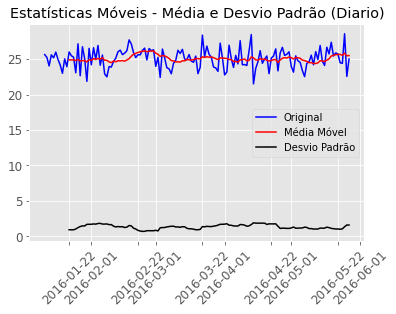


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.184073e+01
Valor-p                         7.600690e-22
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    1.370000e+02
Valor Crítico (1%)             -3.479007e+00
Valor Crítico (5%)             -2.882878e+00
Valor Crítico (10%)            -2.578149e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [45]:
testa_estacionaridade(df_full_series_Dia, 'Diario')

# Inicio Análise Preditiva

O resultado da decomposição da Série nos mostra que existe sazonalidade no conjunto de dados. Devido a esse fator, iremos realizar o primeiro treinamento do modelo utilizando o modelo **SARIMA**.

In [46]:
df_train.shape[0]

14803

In [47]:
df_test.shape

(14803, 32)

In [48]:
# Split do df_full em 2 novos dfs:
# Irei substituir as informações no df_train e df_test, porém deixando os dados com a msm qtd q antes.
df_train = df_full.iloc[0:df_train.shape[0]+1]
df_test = df_full.iloc[df_train.shape[0]: ]

In [49]:
df_train_series_Dia = df_train[column_target].resample('D').mean()
df_test_series_Dia = df_test[column_target].resample('D').mean()

In [50]:
# Função para medir o desempenho do modelo
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [51]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [52]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
# 7 representa a sazonalidade
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

In [53]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 1) x (1, 0, 0, 7)


In [54]:
# Grid Search
#warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    
    for param_seasonal in seasonal_pdq:
        try:
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:633.509336481391
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:509.6944304305649
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:254.74295636647045
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:199.35958181475482
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:260.37815076402427
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:225.7319534744657
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:218.15029300035127
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:205.39983490387488
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:541.8614167289803
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:437.35102873106416
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:251.85143466798704
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:194.89293010538768
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:262.980287859158
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:225.0699298549675
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:219.72764220584187
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:199.8393397227053
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:267.0589118980979
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:245.66314393080077
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:286

In [55]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                             order = (0, 0, 1),
                                             seasonal_order = (0, 1, 1, 7),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [56]:
# Treinamento (Fit) do modelo
modelo_sarima_fit = modelo_sarima.fit()

In [57]:
# Sumário do modelo
print(modelo_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               rv1   No. Observations:                   69
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                 -94.446
Date:                           Tue, 21 Jul 2020   AIC                            194.893
Time:                                   20:59:09   BIC                            200.804
Sample:                               01-11-2016   HQIC                           197.166
                                    - 03-19-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0618      0.142      0.435      0.663      -0.216       0.340
ma.S.L7       -1.0001    769.558     -0.001

In [58]:
df_test_series_Dia.index.values.min()

numpy.datetime64('2016-03-19T00:00:00.000000000')

In [59]:
df_test_series_Dia.index.values.max()

numpy.datetime64('2016-05-27T00:00:00.000000000')

In [60]:
# Vamos fazer previsões dos dados do TESTE
sarima_predict = modelo_sarima_fit.get_prediction(start = pd.to_datetime('2016-04-23'), 
                                                       end = pd.to_datetime('2016-05-27'),
                                                       dynamic = False)

In [61]:
# Intervalo de confiança
sarima_predict_conf = sarima_predict.conf_int()
sarima_predict_conf

,lower rv1,upper rv1
2016-04-23,22.687864,28.028810
2016-04-24,22.588550,27.956301
2016-04-25,21.775031,27.142883
2016-04-26,22.195494,27.563244
2016-04-27,22.152382,27.493328
2016-04-28,22.737751,28.078697
2016-04-29,22.804213,28.145159
2016-04-30,22.687864,28.028810
2016-05-01,22.588550,27.956301
2016-05-02,21.775031,27.142883


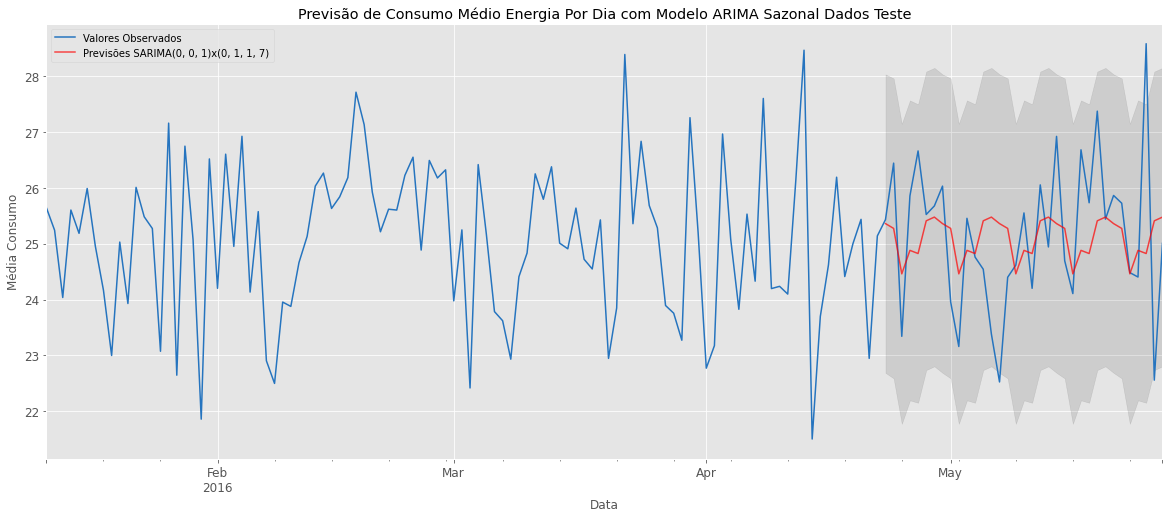

In [62]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_full_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf.index,
                # lower sales
                sarima_predict_conf.iloc[:, 0],
                # upper sales
                sarima_predict_conf.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Médio Energia Por Dia com Modelo ARIMA Sazonal Dados Teste')
plt.xlabel('Data')
plt.ylabel('Média Consumo')
plt.legend()
plt.show()

### Compreendendo o resultado:

- Azul: A série completa (df_full_series_Dia)

- Vermelho: Dados Previstos pelo modelo.

Foi informado dados do df_test_series_Dia para o modelo aplicar a previsão.

In [63]:
# Calculando a performance
sarima_results_treino = performance(df_test_series_Dia, sarima_predict.predicted_mean)
sarima_results_treino

MSE das previsões é 1.73
RMSE das previsões é 1.32
MAPE das previsões é 3.92


# MODELO SARIMA COM VARIÁVEL EXÓGENA

In [64]:
feriados = pd.Series()

# Como nosso dataset aparenta ser da Bélgica, baseado na informação do aeroporto, estamos procurando feriados no ano.
for i, feriado in holidays.Belgium(years = [2016]).items():
    feriados[i] = feriado

In [65]:
feriados_df = pd.DataFrame(feriados)

In [66]:
# Reset do index para ajustar os nomes das colunas
feriados_df.reset_index(level = 0, inplace = True)
feriados_df.columns = ['data_feriado', 'feriado']
# Visualiza
feriados_df.head()
feriados_df['data_feriado'] = pd.to_datetime(feriados_df['data_feriado'])

In [67]:
# Função
def adiciona_feriado(x):
    
    # Aplica a regra
    batch_df = feriados_df.apply(lambda y: 1 if (x['data'] == y['data_feriado']) else None, axis=1)
    
    # Limpa valores nulos
    batch_df = batch_df.dropna(axis = 0, how = 'all')  
    
    # Se estiver vazio, preenche com 0
    if batch_df.empty:
        batch_df = 0
    else: 
        batch_df = batch_df.to_string(index = False)
        
    return batch_df

In [68]:
# Cria um dataframe a partir da série
Frame_means = pd.DataFrame(df_train_series_Dia)

# Reset do índice para ajustar as colunas (podia ter feito tudo isso em um comando, ms didaticamente deixamos assim)
Frame_means.reset_index(level = 0, inplace = True)

# Ajusta o nome das colunas
Frame_means.columns = ['data', 'rv1']
Frame_means.head()

# Aplicamos a função e criamos a coluna feriado
Frame_means['feriado'] = Frame_means.apply(adiciona_feriado, axis = 1)

# Convertendo a coluna feriado para inteiro
Frame_means['feriado'] = pd.to_numeric(Frame_means['feriado'], downcast = 'integer')

# Vamos definir a order_date como índice
Frame_means.set_index("data", inplace = True)

In [69]:
df_train.columns

Index(['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'rv1', 'nsm', 'weekend', 'day_of_week', 'month', 'day'],
      dtype='object')

In [70]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_treino = sm.add_constant(Frame_means['feriado'])
exog_var_treino

,const,feriado
data,,
2016-01-11,1.0,0
2016-01-12,1.0,0
2016-01-13,1.0,0
2016-01-14,1.0,0
2016-01-15,1.0,0
...,...,...
2016-03-15,1.0,0
2016-03-16,1.0,0
2016-03-17,1.0,0


In [71]:
# Grid Search
warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                            exog_var_treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:231.414204591192
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:214.75638389347588
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:258.7429563665687
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:203.3595818128751
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:217.77893429912044
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:212.95867666248836
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:222.15029300043113
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:209.39983490386103
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:230.91075136570143
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:211.91264247951062
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:255.85143466807884
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:198.8929301048181
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:219.62562301129344
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:213.60238098508282
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:223.72764220578412
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:203.83933972279476
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:271.0589118965636
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:249.6631439307659
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:

In [72]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                             exog_var_treino,
                                             order = (0, 0, 1),
                                             seasonal_order = (0, 1, 1, 7),
                                             enforce_stationarity = False,
                                             enforce_invertibility=False)

In [73]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [74]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               rv1   No. Observations:                   69
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                 -94.446
Date:                           Tue, 21 Jul 2020   AIC                            198.893
Time:                                   20:59:16   BIC                            208.744
Sample:                               01-11-2016   HQIC                           202.681
                                    - 03-19-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.937e-08   9.83e+05   8.08e-14      1.000   -1.93e+06    1.93e+06
feriado             0        nan        nan

In [75]:
df_train_series_Dia.index.values.min()

numpy.datetime64('2016-01-11T00:00:00.000000000')

In [76]:
df_train_series_Dia.index.values.max()

numpy.datetime64('2016-03-19T00:00:00.000000000')

In [81]:
# Vamos fazer previsões um passo a frente
sarima_predict_2_treino = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2016-01-20'), 
                                                       end = pd.to_datetime('2016-03-19'),
                                                       exog = exog_var_treino['20160120':'20160319'],
                                                       dynamic = True)
# Intervalo de confiança
sarima_predict_conf_2_treino = sarima_predict_2_treino.conf_int()
sarima_predict_conf_2_treino

,lower rv1,upper rv1
2016-01-20,20.435161,27.636884
2016-01-21,22.000333,29.202057
2016-01-22,21.583408,28.785131
2016-01-23,22.385662,29.587385
2016-01-24,21.355116,28.556839
2016-01-25,20.563072,27.764794
2016-01-26,19.397289,26.599011
2016-01-27,20.435161,27.636884
2016-01-28,22.000333,29.202057
2016-01-29,21.583408,28.785131


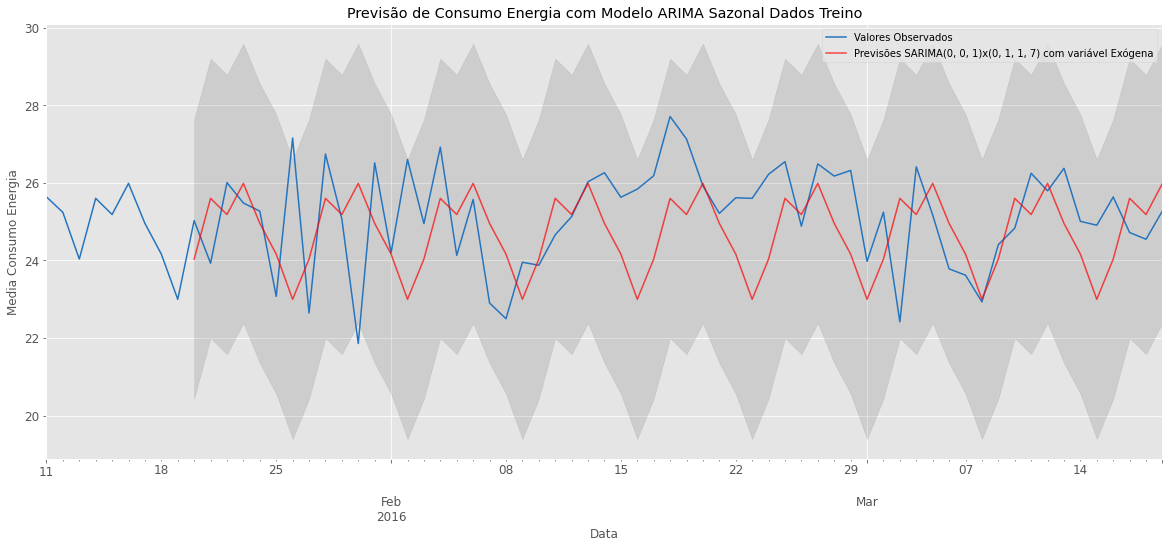

In [82]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_train_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2_treino.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7) com variável Exógena', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2_treino.index,
                # lower sales
                sarima_predict_conf_2_treino.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2_treino.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Energia com Modelo ARIMA Sazonal Dados Treino')
plt.xlabel('Data')
plt.ylabel('Media Consumo Energia')
plt.legend()
plt.show()

In [83]:
# Calculando a performance Dados Treino
sarima_results_2_treino = performance(df_train_series_Dia, sarima_predict_2_treino.predicted_mean)
sarima_results_2_treino

MSE das previsões é 2.44
RMSE das previsões é 1.56
MAPE das previsões é 4.93


In [84]:
# Cria um dataframe a partir da série
Frame_means_teste = pd.DataFrame(df_test_series_Dia)

# Reset do índice para ajustar as colunas (podia ter feito tudo isso em um comando, ms didaticamente deixamos assim)
Frame_means_teste.reset_index(level = 0, inplace = True)

# Ajusta o nome das colunas
Frame_means_teste.columns = ['data', 'rv1']
Frame_means_teste.head()

# Aplicamos a função e criamos a coluna feriado
Frame_means_teste['feriado'] = Frame_means_teste.apply(adiciona_feriado, axis = 1)

# Convertendo a coluna feriado para inteiro
Frame_means_teste['feriado'] = pd.to_numeric(Frame_means_teste['feriado'], downcast = 'integer')

# Vamos definir a order_date como índice
Frame_means_teste.set_index("data", inplace = True)

In [85]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_teste = sm.add_constant(Frame_means_teste['feriado'])
exog_var_teste

,const,feriado
data,,
2016-03-19,1.0,0
2016-03-20,1.0,0
2016-03-21,1.0,0
2016-03-22,1.0,0
2016-03-23,1.0,0
...,...,...
2016-05-23,1.0,0
2016-05-24,1.0,0
2016-05-25,1.0,0


In [86]:
exog_var_teste.shape

(70, 2)

In [87]:
df_test_series_Dia.shape

(70,)

In [88]:
df_test_series_Dia.index.values.min()

numpy.datetime64('2016-03-19T00:00:00.000000000')

In [89]:
df_test_series_Dia.index.values.max()

numpy.datetime64('2016-05-27T00:00:00.000000000')

In [95]:
df_test_series_Dia

date
2016-03-19    26.608171
2016-03-20    22.946320
2016-03-21    23.848071
2016-03-22    28.385275
2016-03-23    25.356405
                ...    
2016-05-23    24.480877
2016-05-24    24.402336
2016-05-25    28.578104
2016-05-26    22.557064
2016-05-27    25.005314
Freq: D, Name: rv1, Length: 70, dtype: float64

In [96]:
exog_var_teste

,const,feriado
data,,
2016-03-19,1.0,0
2016-03-20,1.0,0
2016-03-21,1.0,0
2016-03-22,1.0,0
2016-03-23,1.0,0
...,...,...
2016-05-23,1.0,0
2016-05-24,1.0,0
2016-05-25,1.0,0


In [102]:
# Vamos fazer previsões um passo a frente
sarima_predict_2_teste = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2016-03-19'), 
                                                       end = pd.to_datetime('2016-05-28'),
                                                       exog = exog_var_teste, #['20160320':'20160527'],
                                                       dynamic = True)
# Intervalo de confiança
sarima_predict_conf_2_teste = sarima_predict_2_teste.conf_int()
sarima_predict_conf_2_teste

,lower rv1,upper rv1
2016-03-19,22.627814,27.985450
2016-03-20,22.588675,27.956523
2016-03-21,21.775033,27.142881
2016-03-22,22.195496,27.563243
2016-03-23,22.152384,27.493326
...,...,...
2016-05-24,22.195496,27.563243
2016-05-25,22.152384,27.493326
2016-05-26,22.737752,28.078695
2016-05-27,22.804215,28.145157


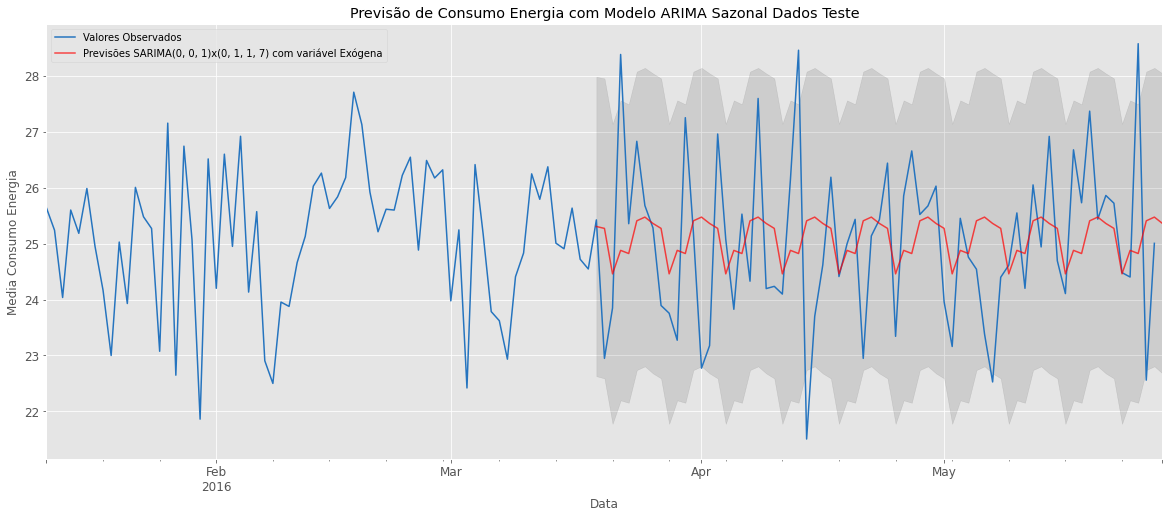

In [103]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_full_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2_teste.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7) com variável Exógena', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2_teste.index,
                # lower sales
                sarima_predict_conf_2_teste.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2_teste.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Energia com Modelo ARIMA Sazonal Dados Teste')
plt.xlabel('Data')
plt.ylabel('Media Consumo Energia')
plt.legend()
plt.show()

In [104]:
# Calculando a performance Dados Teste
sarima_results_2_teste = performance(df_test_series_Dia, sarima_predict_2_teste.predicted_mean)
sarima_results_2_teste

MSE das previsões é 2.29
RMSE das previsões é 1.51
MAPE das previsões é 4.66


# Análise Parcial:

##### Comparando o resultado nos dados de Teste do Modelo SARIMA x Modelo SARIMA Com Variável Exógena, o resultado foi:

- Modelo SARIMA: MSE: 1.19 | RMSE: 1.09 | MAPE: 3.37 | AIC: 321.170
- Modelo SARIMA Com Variável Exógena: MSE: 1.17 | RMSE: 1.08 | MAPE: 3.45 | AIC: 324.607

Com A variável Exógena de Feriados na Bélgica tivemos um aumento do AIC. O resultado não foi tão bom.

Se fosse necessário escolher entre os 2 modelos acima, o modelo escolhido seria o SARIMA com menor AIC.

# MODELO VAR MULTIVARIADO

In [105]:
df_train_Dia_mean = df_train.resample('D').mean()
df_test_Dia_mean = df_test.resample('D').mean()

In [106]:
df_train_Dia_mean.describe()

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,99.084128,5.575237,20.710514,40.391597,19.353576,40.410770,20.804114,40.319584,19.525253,39.652001,...,84.139169,4.530351,39.448349,1.776401,25.116934,43315.782627,0.275362,2.956522,1.971014,15.449275
std,30.768813,4.388621,0.989569,3.617609,1.148010,2.836812,1.030112,3.376091,1.225937,4.719800,...,7.273203,2.261686,5.375051,3.417825,1.270972,3974.602830,0.449969,1.995840,0.766409,8.213218
min,36.730769,0.000000,17.512992,34.416094,16.772294,34.695000,17.585825,34.945177,15.364698,32.657361,...,65.077381,0.983483,29.793651,-5.667619,21.858749,37826.966292,0.000000,0.000000,1.000000,1.000000
25%,78.990826,2.818182,20.222981,37.302154,18.656327,38.205030,20.248509,37.323167,18.881952,35.510329,...,79.379365,2.757971,36.415858,-0.320370,24.200464,42283.928571,0.000000,1.000000,1.000000,9.000000
50%,96.216216,4.761905,20.882574,39.520593,19.163125,39.924671,20.894890,39.843465,19.601250,38.938818,...,85.568910,4.383987,39.407233,1.505663,25.240035,43066.019417,0.000000,3.000000,2.000000,15.000000
75%,120.550459,6.885246,21.334773,43.655746,20.044744,42.595833,21.413092,43.487204,20.270593,43.938422,...,89.250000,6.015015,41.640777,3.960494,26.029102,43644.230769,1.000000,5.000000,3.000000,22.000000
max,167.372881,27.500000,22.444498,46.996890,21.662306,45.565753,22.830841,46.168479,21.433873,49.150008,...,96.946032,10.471154,58.593093,9.220798,27.710254,74212.500000,1.000000,6.000000,3.000000,31.000000


In [107]:
df_train_Dia_mean_Stand = df_train_Dia_mean.copy()

# Colunas que desejo aplicar a Padronização
cols = ['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm']

for i in cols:
    scale = StandardScaler().fit(df_train_Dia_mean[[i]])
    
    df_train_Dia_mean_Stand[i] = scale.transform(df_train_Dia_mean[[i]])

df_train_Dia_mean_Stand.head(2)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,1.042833,5.032421,0.161394,1.750409,0.753850,1.518554,-0.630147,1.672569,0.034286,1.613165,...,0.707841,0.712556,0.243939,0.715836,25.639533,7.830486,0.0,0.0,1.0,11.0
2016-01-12,-0.612882,-0.298967,-0.636568,1.329141,-0.050217,1.200310,-0.793824,1.374762,0.184110,1.041649,...,0.463371,0.564811,-0.479852,0.536839,25.240035,-0.059757,0.0,1.0,1.0,12.0


In [108]:
df_test_Dia_mean_Stand = df_test_Dia_mean.copy()

# Colunas que desejo aplicar a Padronização
cols = ['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm']

for i in cols:
    scale = StandardScaler().fit(df_test_Dia_mean[[i]])
    
    df_test_Dia_mean_Stand[i] = scale.transform(df_test_Dia_mean[[i]])

df_test_Dia_mean_Stand.head(2)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-03-19,-0.721053,0.719646,-0.379042,-1.135581,-0.799209,-0.619296,-1.092186,-1.249623,-0.735952,-1.205934,...,0.643347,-0.270137,-3.565900,-0.956613,26.608171,7.717188,1.0,5.0,3.0,19.0
2016-03-20,0.493969,-0.737110,-0.762150,-0.892931,-1.082429,-0.415282,-0.947776,-0.751714,-1.306554,-0.903955,...,0.525667,-0.307280,-0.446724,-0.934789,22.946320,0.012002,1.0,6.0,3.0,20.0


In [109]:
model = VAR(endog = df_train_Dia_mean_Stand,
            freq = df_train_Dia_mean_Stand.index.inferred_freq)

model_fit = model.fit()

In [110]:
# model_fit.plot_forecast(3);
df_test_Dia_mean_Stand.values.shape

(70, 32)

In [118]:
pred_var = model_fit.forecast(y=df_test_Dia_mean_Stand.values, steps=70)
pred_var

array([[-4.50641594,  0.79980115,  2.74642505, ...,  6.29643327,
         5.15410882, 22.66178447],
       [ 5.12836163,  4.63653579,  1.54026494, ...,  5.18342813,
         5.27445979, 18.93509658],
       [-1.33607002,  3.07730161,  3.86093383, ...,  6.19740915,
         5.6151804 ,  9.35000686],
       ...,
       [-0.13633887, -1.04899012,  1.56834094, ...,  2.97181312,
         7.97838919, 15.78539836],
       [-0.13693157, -1.05589286,  1.5790924 , ...,  2.97172667,
         8.02015049, 15.77794838],
       [-0.1375301 , -1.0628045 ,  1.58983676, ...,  2.97164641,
         8.0619722 , 15.77040973]])

In [119]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Jul, 2020
Time:                     21:05:08
--------------------------------------------------------------------
No. of Equations:         32.0000    BIC:                   -65.1384
Nobs:                     68.0000    HQIC:                  -85.9490
Log likelihood:           1355.00    FPE:                9.57312e-43
AIC:                     -99.6061    Det(Omega_mle):     3.04127e-48
--------------------------------------------------------------------
Results for equation appliances
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.598419         4.019904            0.149           0.882
L1.appliances         -0.328172         0.213707           -1.536           0.125
L1.lights              0.476027         0.242936   

In [120]:
pred = pd.DataFrame(index=range(0,len(pred_var)),columns=[df_train_Dia_mean_Stand.columns])
pred

#len(pred_var)

for j in range(0,len(df_train_Dia_mean_Stand.columns)):
    for i in range(0, len(pred_var)):
        pred.iloc[i][j] = pred_var[i][j]

In [121]:
pred_var

array([[-4.50641594,  0.79980115,  2.74642505, ...,  6.29643327,
         5.15410882, 22.66178447],
       [ 5.12836163,  4.63653579,  1.54026494, ...,  5.18342813,
         5.27445979, 18.93509658],
       [-1.33607002,  3.07730161,  3.86093383, ...,  6.19740915,
         5.6151804 ,  9.35000686],
       ...,
       [-0.13633887, -1.04899012,  1.56834094, ...,  2.97181312,
         7.97838919, 15.78539836],
       [-0.13693157, -1.05589286,  1.5790924 , ...,  2.97172667,
         8.02015049, 15.77794838],
       [-0.1375301 , -1.0628045 ,  1.58983676, ...,  2.97164641,
         8.0619722 , 15.77040973]])

In [122]:
df_forecast = pd.DataFrame(pred_var, index=df_test_Dia_mean_Stand.index, columns=df_test_Dia_mean_Stand.columns + '_2d')

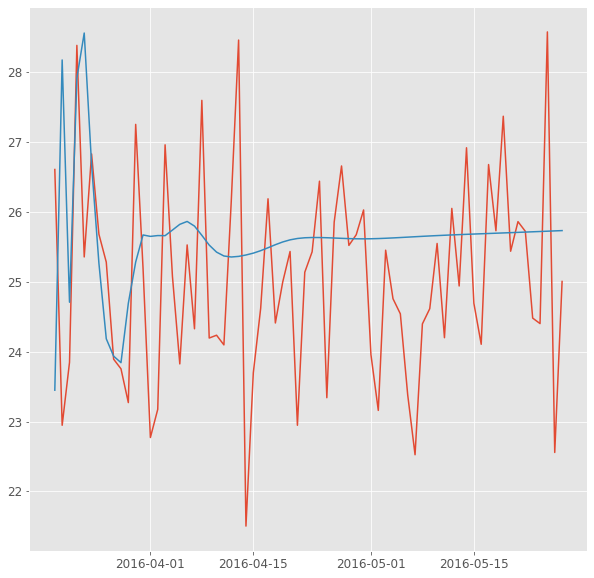

In [123]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(df_test_Dia_mean_Stand['rv1'])
ax.plot(df_forecast['rv1_2d']);

In [124]:
performance(df_forecast['rv1_2d'], df_test_Dia_mean_Stand['rv1'])

MSE das previsões é 2.79
RMSE das previsões é 1.67
MAPE das previsões é 4.97


## Modelo VAR com Multivariaveis não foi capaz de prever o consumo médio de energia Diário. Resultado muito ruim.

## Irei realizar o estudo agora utilizando o Modelo Gradient Boosting para prever o consumo médio de energia Diário.

## GRADIENT BOOSTING

In [125]:
#X = df_full.loc[:, df_full.columns != column_target]
#y = df_full.loc[:, df_full.columns == column_target]

X_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns != column_target]
Y_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns == column_target]

X_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns != column_target]
Y_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns == column_target]

In [126]:
X_train.shape
#Y_train.shape

(69, 31)

In [127]:
X_test.shape
#Y_test.shape

(70, 31)

In [128]:
# GRID SEARCH para identificar os melhores parametros.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 5, 6],
              'min_samples_leaf': [3, 4, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [400, 700, 1000, 2000, 3000]
              }

# Regressor
est = GradientBoostingRegressor()

# Modelo criado com GridSearchCV
gs_cv = GridSearchCV(est, param_grid, scoring = 'neg_mean_squared_error', n_jobs = 4, return_train_score=True).fit(X_train, Y_train)

# Imprime os melhors parâmetros
print('Melhores Hiperparâmetros: %r' % gs_cv.best_params_)

Melhores Hiperparâmetros: {'learning_rate': 0.001, 'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.3}


In [129]:
gs_cv.best_params_

{'learning_rate': 0.001,
 'max_depth': 4,
 'min_samples_leaf': 3,
 'n_estimators': 400,
 'subsample': 0.3}

In [130]:
#est = GradientBoostingRegressor()

#params = {'min_samples_leaf': 3}
#est.set_params(**gs_cv.best_params_)
#est.fit(X_train, Y_train)

In [131]:
est = GradientBoostingRegressor(n_estimators = 6000, max_depth =8, learning_rate = 0.001, min_samples_leaf=4, subsample=0.3)
est.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=8, min_samples_leaf=4,
                          n_estimators=6000, subsample=0.3)

In [132]:
yhat = est.predict(X_test)
yhat

array([25.63913698, 25.54674106, 24.87027523, 24.84138428, 25.22255271,
       25.03806344, 25.44733565, 24.3519973 , 24.72801321, 24.28493042,
       24.65632493, 25.19808225, 24.97086557, 25.07343034, 24.40520645,
       24.43405292, 24.67816424, 24.75660376, 24.23651866, 24.05511721,
       24.2379933 , 24.23377143, 24.63364817, 24.87089125, 25.07877057,
       25.55094061, 25.23754925, 25.66680191, 26.08711583, 25.60427524,
       24.9881294 , 24.8433107 , 25.55087473, 25.49103868, 25.78504021,
       26.09007642, 25.75626634, 24.4885016 , 24.4930584 , 24.73017904,
       25.27325826, 25.0902164 , 25.41591558, 24.93795589, 24.86765797,
       25.21265999, 24.85744013, 25.08736059, 24.90193762, 24.22725547,
       24.31618242, 23.96299409, 23.78471079, 24.33036888, 24.10191561,
       24.35247278, 25.02566695, 25.31979991, 25.13032209, 25.37195757,
       24.99080555, 24.80914983, 25.40978501, 24.8553088 , 24.78886845,
       24.68145176, 25.0588292 , 25.33265929, 24.64457859, 24.49

In [133]:
predy = pd.DataFrame(index=range(0,len(yhat)), columns=['rv1_pred'])

j = 0
for i in range(0, len(yhat)):
    predy.iloc[i][j] = yhat[i]

In [134]:
predy

,rv1_pred
0,25.6391
1,25.5467
2,24.8703
3,24.8414
4,25.2226
...,...
65,24.6815
66,25.0588
67,25.3327
68,24.6446


In [135]:
predy.index = Y_test.index

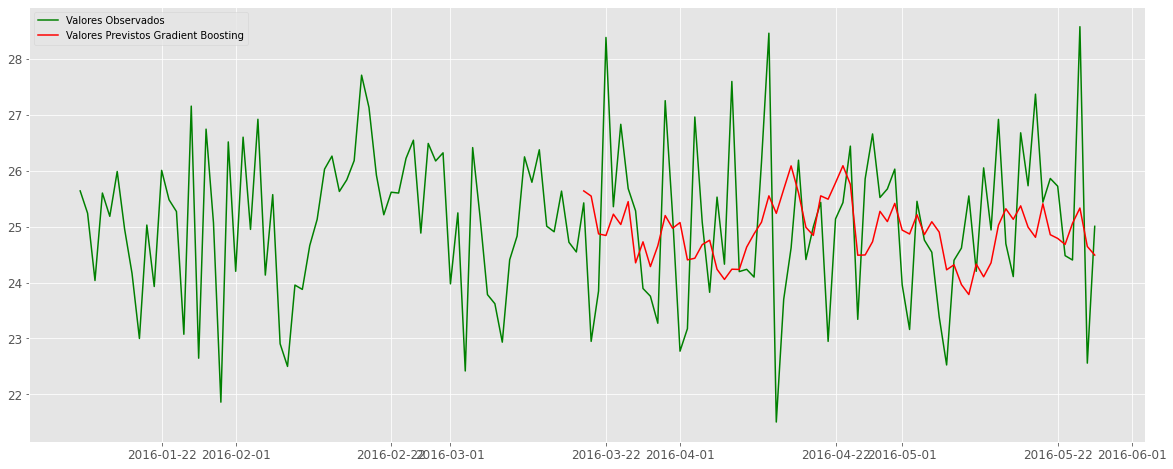

In [136]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(df_full_series_Dia, color = "green", label = 'Valores Observados')
ax.plot(pd.Series(predy['rv1_pred']), color = 'red', label = 'Valores Previstos Gradient Boosting')
plt.legend();

In [137]:
performance(pd.Series(predy['rv1_pred']), pd.Series(Y_test['rv1']))

MSE das previsões é 2.21
RMSE das previsões é 1.49
MAPE das previsões é 4.68


### REGRESSÃO LINEAR MULTILA

In [138]:
X_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns != column_target]
Y_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns == column_target]

X_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns != column_target]
Y_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns == column_target]

In [139]:
modelo = LinearRegression()
modelo_result = modelo.fit(X_train, Y_train)

In [140]:
yhat2 = modelo_result.predict(X_test)

In [141]:
# output list  
# function used for removing nested  
# lists in python.  
def reemovNestings(yhat2): 
    
    for i in yhat2: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            output.append(i) 
    
    return output

In [142]:
output = []
yhat2 = reemovNestings(yhat2.tolist())

In [143]:
yhat2

[26.60843056005141,
 23.402418569368535,
 24.25366318221444,
 22.34248784153946,
 24.234981191545092,
 22.57478277588158,
 23.96005171456295,
 25.819756655474535,
 23.55329744155462,
 23.1275966360888,
 23.069275838274937,
 24.52394223697257,
 24.196420624470555,
 22.954838200781882,
 24.62634540840668,
 25.727147717370254,
 25.741322531798474,
 27.124770694462303,
 26.146368446391858,
 22.063990979702158,
 23.747075083617805,
 21.795977468342823,
 23.450976341537334,
 22.903761953571134,
 21.633267576623602,
 25.352093382819724,
 25.761217630010417,
 26.616616802724163,
 24.69963338361162,
 23.8804465693491,
 19.40372350174332,
 19.834522036047996,
 16.54861975006351,
 18.32541177305486,
 21.88684933904461,
 20.707649799484095,
 22.463824503718506,
 24.285173488286922,
 18.270049513336502,
 20.202253659992138,
 17.602456403574784,
 23.133449259706477,
 23.182059255649655,
 20.01017677241104,
 18.32946680161053,
 18.532887710786206,
 16.76731714787958,
 14.415215584742365,
 20.47531096

In [144]:
predy2 = pd.DataFrame(index=range(0,len(yhat2)), columns=['rv1_pred'])

j = 0
for i in range(0, len(yhat2)):
    predy2.iloc[i][j] = yhat2[i]

In [145]:
predy2.index = Y_test.index

In [146]:
predy2

,rv1_pred
date,
2016-03-19,26.6084
2016-03-20,23.4024
2016-03-21,24.2537
2016-03-22,22.3425
2016-03-23,24.235
...,...
2016-05-23,23.1298
2016-05-24,23.2124
2016-05-25,24.5831


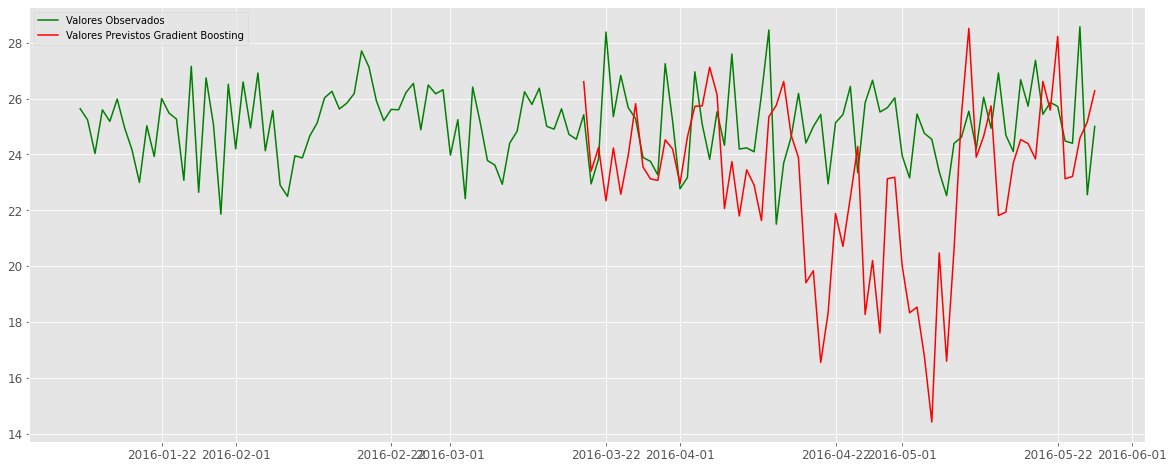

In [147]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(df_full_series_Dia, color = "green", label = 'Valores Observados')
ax.plot(pd.Series(predy2['rv1_pred']), color = 'red', label = 'Valores Previstos Gradient Boosting')
plt.legend();

In [148]:
performance(pd.Series(predy2['rv1_pred']), pd.Series(Y_test['rv1']))

MSE das previsões é 13.76
RMSE das previsões é 3.71
MAPE das previsões é 13.97


# Avaliando todos os resultados.


SARIMA

- AIC:191.85300524599475
- MSE das previsões é 1.73
- RMSE das previsões é 1.32
- MAPE das previsões é 3.92

SARIMA COM VARIAVEL EXÓGENA

- AIC:195.8530052510325
- MSE das previsões é 2.29
- RMSE das previsões é 1.51
- MAPE das previsões é 4.66

VAR MULTIVARIAVEL

- MSE das previsões é 2.79
- RMSE das previsões é 1.67
- MAPE das previsões é 4.97

GRADIENT BOOSTING REGRESSOR

- MSE das previsões é 2.21
- RMSE das previsões é 1.49
- MAPE das previsões é 4.68

REGRESSÃO LINEAR

- MSE das previsões é 13.76
- RMSE das previsões é 3.71
- MAPE das previsões é 13.97

### Diante o Cenário, caso o objetivo seja prever o consumo em um determinado dia, seria utilizado o Modelo SARIMA, pois o SARIMA com Variável Exógena, não apresentou um ganho representativo e teve uma queda no AIC.

### Caso o objetivo seja prever o consumo diário sem levar em conta um dia especifico, o Modelo Gradient Boosting seria melhor recomendado devido a taxa do RMSE ser relativamente menor.